In [45]:
#https://www.kaggle.com/piotrstanczyk/gfootball-template-bot  G-FOOTBALL TEMPLATE BOT
# Install:
# Kaggle environments.
#!git clone https://github.com/Kaggle/kaggle-environments.git
#!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v6 https://github.com/Georgemouts/football.git #https://github.com/google-research/football.git  
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.8.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

!pip install utils
#!pip install learning

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 2s (126 kB/s)
Reading package lis

In [46]:
#from gfootball.env.football_env import FootballEnv
#from kaggle_environments import make
from gfootball.env.config import Config
import gfootball.env as football_env

#import dqn libraries
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import pandas as pd
import itertools
import utils
import random
from collections import deque
import matplotlib.pyplot as plt
#from utils import plot_learning_curve
#import env 
import gym
import gfootball 
import math
import os
import utils
#from utils import plotLearning

#from dueling_dqn_torch import Agent

In [47]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')

new_observation,reward,done,info = env.step(5)
print(new_observation)

[ 9.0165710e-04  4.9248206e-11  3.2361329e-03  2.4654957e-11
  1.0110294e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00
  2.0000000e-02 -0.0000000e+00  1.1059734e-01 -0.0000000e+00
  0.0000000e+00 -1.9182914e-03  1.0000000e+00  0.0000000e+00
  0.0000000e+00]


In [48]:
class DeepQNetwork(nn.Module):
  def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
    super(DeepQNetwork,self).__init__()
   # self.lr=lr
    self.input_dims=input_dims
    self.fc1_dims=fc1_dims
    self.fc2_dims=fc2_dims
    
    self.n_actions=n_actions
    
    self.fc1=nn.Linear(*self.input_dims,self.fc1_dims) #pass list of observations as input
    self.fc2=nn.Linear(self.fc1_dims,self.fc2_dims)
    self.fc3=nn.Linear(self.fc2_dims,self.n_actions)
    #self.fc4=nn.Linear(self.fc3_dims,self.n_actions) #output number action

    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss=nn.MSELoss()
    self.device =T.device('cuda:0' if T.cuda.is_available() else 'cpu' )
    self.to(self.device)

  def forward(self,state):
   
    x=F.relu(self.fc1(state))
    x=F.relu(self.fc2(x))
    actions=self.fc3(x)
    #x=F.relu(self.fc3(x))
    return actions

In [49]:
class Agent():
  def __init__(self,gamma,epsilon, lr , input_dims , batch_size ,n_actions, max_mem_size = 10000  , eps_end=0.01 , eps_dec = 5e-4):
    self.gamma=gamma
    self.epsilon =epsilon
    self.lr=lr
    self.eps_min=eps_end
    self.eps_dec=eps_dec
   
    self.action_space =[i for i in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    #self.n_actions=n_actions
    self.mem_cntr =0 # keep track of the position of first available memory 

    self.Q_eval = DeepQNetwork(self.lr,n_actions=n_actions,input_dims= input_dims, fc1_dims=60, fc2_dims=60)

    self.state_memory = np.zeros((self.mem_size,*input_dims),dtype =np.float32)
    self.new_state_memory= np.zeros((self.mem_size , *input_dims),dtype=np.float32)

    self.action_memory=np.zeros(self.mem_size , dtype=np.int32) #discrete actions 
    self.reward_memory=np.zeros(self.mem_size,dtype= np.float32)
    self.terminal_memory= np.zeros(self.mem_size,dtype=bool)


  def store_transition(self,state,action,reward,new_state , done ):
    index = self.mem_cntr% self.mem_size

    self.state_memory[index]= state
    self.new_state_memory[index]= new_state
    self.reward_memory[index]= reward
    self.action_memory[index]= action  #which action is taken 
    self.terminal_memory[index]= done

    self.mem_cntr +=1
    

  def choose_action(self,observation):
    if np.random.random()> self.epsilon:
      
      state =T.tensor([observation]).to(self.Q_eval.device) #turn observation to tensor and send it to device for computations
      action_list = self.Q_eval.forward(state) #returns the values of each action
      action = T.argmax(action_list).item()
      #print("exploit:",action)
    else:     #
      
      action = np.random.choice(self.action_space)
      #print("explore:",action)
    return action

  def learn(self):    #fill batch size then learn 
    if self.mem_cntr < self.batch_size :
     
      return
    
    
    self.Q_eval.optimizer.zero_grad()

    #calculate the position of max memory / extract subset of max memories
    max_mem =min(self.mem_cntr , self.mem_size)
    


    batch=np.random.choice(max_mem,self.batch_size,replace=False) #We dont keep selecting the same memories more than once
     
    #batch = np.random.permutation(max_mem)[:self.batch_size]
    #mem = np.array(exp_buffer)[perm_batch]

    #batch=np.random.choice(max_mem,self.batch_size,replace=False)
    batch_index = np.arange(self.batch_size , dtype=np.int32)

    state_batch=T.tensor(self.state_memory[batch]).to(self.Q_eval.device) #make numpy array a pytorch tensor
    new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
    reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
    terminal_batch= T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

    action_batch = self.action_memory[batch] 
  
    q_eval = self.Q_eval.forward(state_batch)[batch_index,action_batch] #EXEI THEMA
    q_next = self.Q_eval.forward(new_state_batch)

    q_next[terminal_batch] = 0.0
    q_target = reward_batch +self.gamma * T.max(q_next,dim=1)[0] #max value of next state

    loss = self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
    loss.backward()
    self.Q_eval.optimizer.step()

    self.epsilon = self.epsilon - self.eps_dec if (self.epsilon > self.eps_min)  else self.eps_min

In [50]:

class All_prints():
  
  def __init___(self,step):
    self.step=step
    #self.RewBuffer = RewBuffer
    self.reward=reward

  def printstats(self,step,rew_list,eps_reward,epsilon):  #Kaleitai otan ginei done , diladi otan teleiosei ena paixnidi
    self.step=step
    self.rew_list=rew_list
    self.eps_reward=eps_reward
    self.epsilon=epsilon
    print("-->Episode:",i%3000 + 1,"\t","Episode Reward:",eps_reward,"\t Epsilon",agent.epsilon,"<--")
    #print("Step",step)
    print("lista apo rewards mexri tora" ,self.rew_list)
    print("Avg reward", np.mean(self.rew_list))
    print("---------------------------------------------------")

  def print_who_scored(self, reward):
    self.reward=reward
    if(self.reward==1):
      print("our team scored !!!")
    elif(self.reward ==-1):
      print("opponent team scored")
    
    
 
  def rew_graph(self,rew_list,num_of_eps):
      self.rew_list=rew_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.rew_list)
      plt.xlabel('Episode')
      plt.ylabel('Rewards')
      plt.grid(True)
      plt.show()

  def step_graph(self,step_list,num_of_eps):
      self.step_list=step_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.step_list)
      plt.xlabel('Episodes')
      plt.ylabel('Steps_to_score')
      plt.grid(True)
      plt.show()


  def score_graph(self,score_list,num_of_eps):
      self.score_list=score_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.score_list)
      plt.xlabel('Episode')
      plt.ylabel('Score')
      plt.grid(True)
      plt.show()

PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
dribble prin ton antipalo
PROSOXI lathos sprint
antipalos
antipalos
klepsimo
[ 3.71067286e-01 -1.34243565e-02  7.17184134e-03  8.53002362e-04
  4.08718944e-01 -1.05237268e-01  3.77612945e-04 -3.83625762e-03
  4.05218929e-01 -1.11200750e-01  1.10522911e-01 -4.61132172e-03
 -3.07431282e-03 -2.38236450e-02  0.00000000e+00  0.00000000e+00
  1.00000000e+00]
---Episode reward: -125.16239773117759 score [0] steps 70 episode= 0 ---
---Avg reward last: -125.16239773117759 Avg score last 0.0 Avg steps 70.0 episode= 0 ---
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
dribble prin ton antipalo
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sp

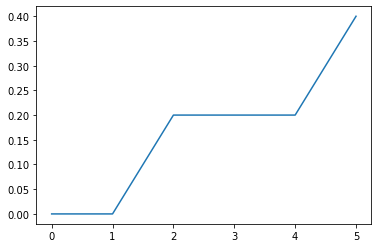

goal episode 51 step= 114
---Episode reward: 60.97568106289772 score [1] steps 115 episode= 51 ---
antipalos
antipalos
klepsimo
[ 0.98434263 -0.05019756  0.00896621 -0.00420478  0.9851003  -0.04140082
  0.00807025 -0.00498032  0.995456   -0.0544568   0.1167729   0.00626879
 -0.00320487  0.02887937  0.          0.          1.        ]
---Episode reward: -125.02440987944523 score [0] steps 112 episode= 52 ---
goal episode 53 step= 94
---Episode reward: 60.977684546846774 score [1] steps 95 episode= 53 ---
goal episode 54 step= 120
---Episode reward: 60.97748961867245 score [1] steps 121 episode= 54 ---
mpala ektos orion
---Episode reward: -15.109245124842145 score [0] steps 88 episode= 55 ---
goal episode 56 step= 88
---Episode reward: 60.97852759143336 score [1] steps 89 episode= 56 ---
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika


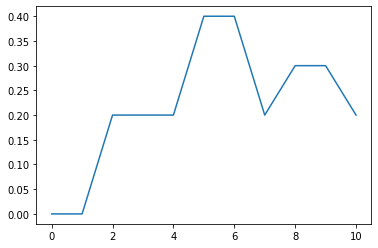

dribble prin ton antipalo
antipalos
antipalos
klepsimo
[ 5.21275699e-01 -8.53017438e-03  1.08924927e-02 -2.75099534e-04
  5.30273378e-01 -2.23139534e-03  1.14534246e-02  6.20364517e-05
  5.47751248e-01 -4.76176571e-03  1.11280546e-01  4.72444110e-03
 -1.03550492e-05  1.48664124e-03  0.00000000e+00  0.00000000e+00
  1.00000000e+00]
---Episode reward: -125.11618340818984 score [0] steps 62 episode= 101 ---
ball is out -15 episode 102 Ball Position 1.0077205 0.051612813 0.12917687 step= 101
---Episode reward: -20.02675244728803 score [0] steps 102 episode= 102 ---
dribble prin ton antipalo
Mpala piso apo kentro
---Episode reward: -25.28448072621819 score [0] steps 71 episode= 103 ---
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
shout entos periohis Ball Position 0.65996236 -0.0042971536 0.11834577 episode 104 step= 74
goal episode 104 step= 93
---Episode reward:

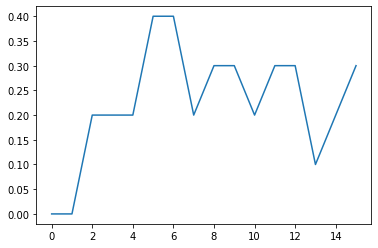

antipalos
PROSOXI lathos sprint
Mpala piso apo kentro
---Episode reward: -18.286346454463093 score [0] steps 135 episode= 151 ---
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
shout entos periohis Ball Position 0.6757791 -0.012763271 0.11111471 episode 152 step= 71
goal episode 152 step= 80
---Episode reward: 50.98146878542828 score [1] steps 81 episode= 152 ---
PROSOXI lathos sprint
mpala ektos orion
---Episode reward: -25.107076393093767 score [0] steps 100 episode= 153 ---
dribble prin ton antipalo
ball is out -15 episode 154 Ball Position 1.0146357 -0.28507566 0.108607486 step= 144
---Episode reward: -20.088796947430385 score [0] steps 145 episode= 154 ---
shout entos periohis Ball Position 0.6596251 0.010465225 0.11436955 episode 155 step= 76
Ball is out by player - 5
---Episode reward: -10.037099476075534 score [0] steps 101 episode= 155 ---
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton a

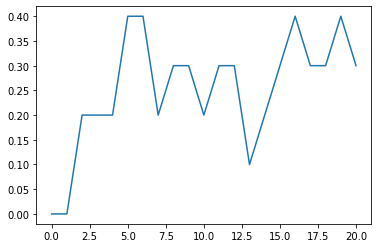

antipalos
antipalos
klepsimo
[ 4.1088998e-01 -1.0482430e-02  5.4143001e-03 -3.6834739e-04
  4.0967903e-01 -1.8754211e-03 -6.5749949e-03  9.8407669e-05
  4.1395760e-01  3.2130905e-04  1.3839975e-01 -8.1003532e-03
  5.9380487e-04  5.6157351e-02  0.0000000e+00  0.0000000e+00
  1.0000000e+00]
---Episode reward: -120.15631275097348 score [0] steps 51 episode= 201 ---
ball is out -15 episode 202 Ball Position 1.0084726 0.12318632 0.11186089 step= 105
---Episode reward: -20.043029964112076 score [0] steps 106 episode= 202 ---
dribble prin ton antipalo
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
Mpala piso apo kentro
---Episode reward: -25.28540583601222 score [0] steps 68 episode= 203 ---
PROSOXI lathos sprint
ball is out -15 episode 204 Ball Position 1.0154195 -0.15040231 0.36347094 step= 90
---Episode reward: -20.05116574307302 score [0] steps 91 episode= 204 ---
Ball is out by player - 5
---Episode reward: -10.02727554256653

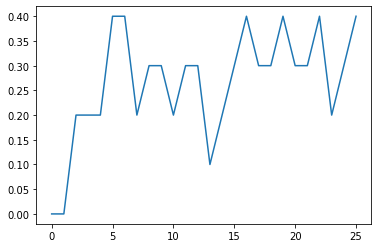

shout entos periohis Ball Position 0.67382056 0.0073927827 0.111775294 episode 251 step= 75
goal episode 251 step= 88
---Episode reward: 60.980321970579745 score [1] steps 89 episode= 251 ---
antipalos
antipalos
klepsimo
[ 5.3131151e-01  1.7718817e-03  9.1910362e-03  2.3171662e-08
  6.4840281e-01  3.0781943e-02  4.5902589e-03  9.9220348e-04
  6.5000880e-01  3.3763360e-02  1.1117016e-01 -1.5377724e-03
  9.4915595e-04  9.4509806e-04  0.0000000e+00  0.0000000e+00
  1.0000000e+00]
---Episode reward: -120.08609526985975 score [0] steps 79 episode= 252 ---
shout entos periohis Ball Position 0.6632975 0.031433687 0.10864174 episode 253 step= 75
Ball is out by player - 5
---Episode reward: -10.025469021236507 score [0] steps 88 episode= 253 ---
antipalos
antipalos
klepsimo
[ 0.73445475  0.08334389  0.00335313  0.00468272  0.7490444   0.08524369
  0.00648577  0.00436753  0.7473981   0.08991265  0.34627384  0.00610365
  0.00440614 -0.11341788  0.          0.          1.        ]
---Episode rewar

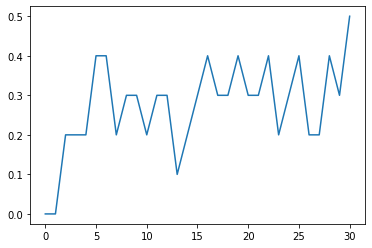

shout entos periohis Ball Position 0.6572006 0.010115987 0.11435114 episode 301 step= 76
Ball is out by player - 5
---Episode reward: -10.064937551747871 score [0] steps 88 episode= 301 ---
shout entos periohis Ball Position 0.6663088 0.013639986 0.11923999 episode 302 step= 75
Ball is out by player - 5
---Episode reward: -10.02981922473335 score [0] steps 90 episode= 302 ---
antipalos
mpala ektos orion
---Episode reward: -20.108149041331227 score [0] steps 101 episode= 303 ---
shout entos periohis Ball Position 0.71489906 0.029533891 0.110484585 episode 304 step= 75
goal episode 304 step= 83
---Episode reward: 60.98248598262744 score [1] steps 84 episode= 304 ---
antipalos
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
antipalos
klepsimo
[ 4.3922937e-01 -1.0440210e-02  7.4574393e-03 -3.6029017e-04
  4.4137812e-01 -1.9310645e-03 -1.2341120e-05 -2.4729889e-04
  4.2853242e-01 -1.1252713e-02  2.5399727e-01 -2.0584143e-03
 -9.3727681e-04 -2.8016120e

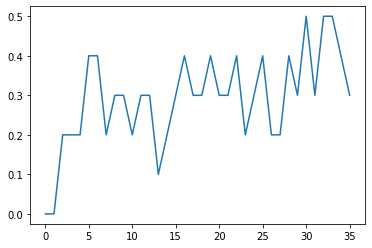

antipalos
antipalos
klepsimo
[ 5.39299130e-01 -2.26802845e-02  7.67777953e-03 -2.69055087e-03
  6.70833945e-01 -1.78426579e-02  5.59021439e-03  1.27437015e-04
  6.76982820e-01 -1.90787744e-02  1.09285995e-01 -2.37484020e-03
  5.33320745e-05 -1.21901194e-02  0.00000000e+00  0.00000000e+00
  1.00000000e+00]
---Episode reward: -120.07761647912037 score [0] steps 80 episode= 351 ---
shout entos periohis Ball Position 0.6663744 0.04022583 0.109314494 episode 352 step= 72
goal episode 352 step= 86
---Episode reward: 60.97848612541891 score [1] steps 87 episode= 352 ---
shout entos periohis Ball Position 0.7424346 -0.015747633 0.11075805 episode 353 step= 78
goal episode 353 step= 88
---Episode reward: 60.975311943997696 score [1] steps 89 episode= 353 ---
Ball is out by player - 5
---Episode reward: -10.02792685444006 score [0] steps 96 episode= 354 ---
antipalos
antipalos
klepsimo
[ 5.2431357e-01 -3.5790750e-03  9.1910362e-03  1.2477049e-07
  6.4046711e-01  2.2809941e-02  5.5488418e-03  4.6

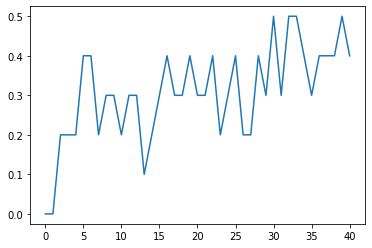

antipalos
antipalos
klepsimo
[ 5.4968679e-01 -1.4378059e-02  9.1913864e-03 -1.4259484e-08
  6.7633343e-01 -3.4145694e-02  4.9163313e-03 -8.2089001e-04
  6.7928666e-01 -3.6950517e-02  1.1075400e-01 -1.5746088e-03
 -1.0110870e-03  7.5399773e-03  0.0000000e+00  0.0000000e+00
  1.0000000e+00]
---Episode reward: -120.07751076587358 score [0] steps 81 episode= 401 ---
Ball is out by player - 5
---Episode reward: -10.032372162865832 score [0] steps 104 episode= 402 ---
goal episode 403 step= 85
---Episode reward: 60.97893014180193 score [1] steps 86 episode= 403 ---
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
shout entos periohis Ball Position 0.6788928 -0.023552993 0.11296774 episode 404 step= 72
goal episode 404 step= 83
---Episode reward: 60.98036970270982 score [1] steps 84 episode= 404 ---
mpala ektos orion
---Episode reward: -20.1

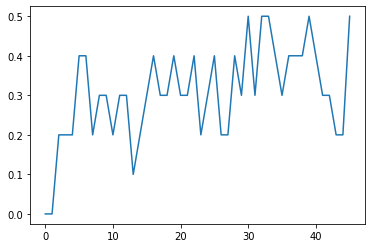

shout entos periohis Ball Position 0.67455935 0.017703535 0.111419655 episode 451 step= 71
goal episode 451 step= 81
---Episode reward: 60.986595796531454 score [1] steps 82 episode= 451 ---
goal episode 452 step= 82
---Episode reward: 60.98124937768574 score [1] steps 83 episode= 452 ---
shout entos periohis Ball Position 0.6777092 0.042767584 0.11052651 episode 453 step= 72
Ball is out by player - 5
---Episode reward: -10.018757968365795 score [0] steps 85 episode= 453 ---
antipalos
antipalos
klepsimo
[ 8.0949187e-01  7.1357012e-02  1.2207037e-02  2.2892540e-03
  8.0538112e-01  7.9564355e-02  9.6148215e-03  7.3789863e-04
  8.2408869e-01  7.8851156e-02  4.1664305e-01  8.5036261e-03
  1.6122217e-03 -1.4442256e-01  0.0000000e+00  0.0000000e+00
  1.0000000e+00]
---Episode reward: -125.0408251645417 score [0] steps 92 episode= 454 ---
mpala ektos orion
---Episode reward: -15.111082421892096 score [0] steps 91 episode= 455 ---
antipalos
antipalos
klepsimo
[ 9.6881056e-01 -1.6279706e-01  1.

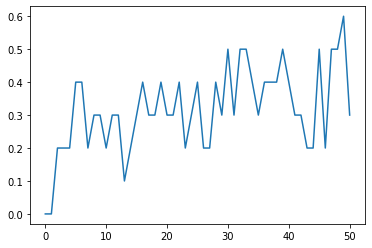

antipalos
mpala ektos orion
---Episode reward: -15.106942928296146 score [0] steps 88 episode= 501 ---
shout entos periohis Ball Position 0.67290944 -0.003446871 0.13524814 episode 502 step= 75
goal episode 502 step= 87
---Episode reward: 60.98305871769089 score [1] steps 88 episode= 502 ---
shout entos periohis Ball Position 0.6755762 0.017244669 0.11027857 episode 503 step= 77
goal episode 503 step= 86
---Episode reward: 50.98259154879439 score [1] steps 87 episode= 503 ---
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanoni

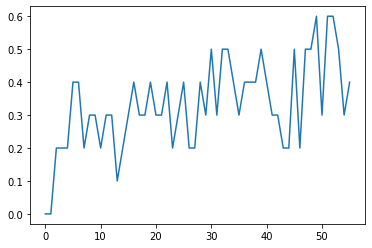

goal episode 551 step= 85
---Episode reward: 60.98451499325682 score [1] steps 86 episode= 551 ---
mpala ektos orion
---Episode reward: -15.181310996949062 score [0] steps 99 episode= 552 ---
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
shout entos periohis Ball Position 0.6654296 -0.026930988 0.10564651 episode 553 step= 72
goal episode 553 step= 81
---Episode reward: 50.978703769769595 score [1] steps 82 episode= 553 ---
shout entos periohis Ball Position 0.6941254 0.01634989 0.11044604 episode 554 step= 77
goal episode 554 step= 89
---Episode reward: 60.98244962227818 score [1] steps 90 episode= 554 ---
shout entos periohis Ball Position 0.6654913 0.03248349 0.121855 episode 555 step= 73
Ball is out by player - 5
---Episode reward: -10.022421382936582 score [0] steps 86 episode= 555 ---
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton a

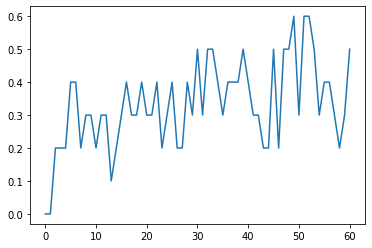

ball is out -15 episode 601 Ball Position 1.0129879 0.117572255 0.11494059 step= 106
---Episode reward: -25.042325886039077 score [0] steps 107 episode= 601 ---
mpala ektos orion
---Episode reward: -20.11373961024636 score [0] steps 109 episode= 602 ---
ball is out -15 episode 603 Ball Position 1.0089698 0.051954426 0.11725731 step= 98
---Episode reward: -25.027117728799567 score [0] steps 99 episode= 603 ---
antipalos
antipalos
klepsimo
[ 9.80370343e-01 -3.65943164e-02  1.38626378e-02 -1.14075874e-07
  9.55885530e-01  1.33803114e-01  3.52579006e-03  2.37574428e-03
  9.55429971e-01  1.37512818e-01  1.10763572e-01 -1.93961489e-03
  2.30077334e-04  7.63576198e-03  0.00000000e+00  0.00000000e+00
  1.00000000e+00]
---Episode reward: -120.04170664569251 score [0] steps 104 episode= 604 ---
shout entos periohis Ball Position 0.67609626 0.026578913 0.10837647 episode 605 step= 75
goal episode 605 step= 88
---Episode reward: 60.97549775680919 score [1] steps 89 episode= 605 ---
antipalos
mpala

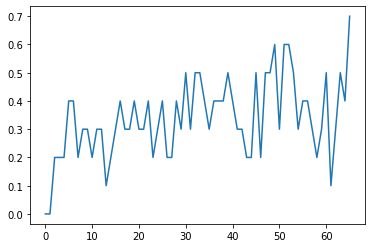

shout entos periohis Ball Position 0.66788644 0.024928728 0.12148053 episode 651 step= 74
Ball is out by player - 5
---Episode reward: -10.034501772948376 score [0] steps 93 episode= 651 ---
mpala ektos orion
---Episode reward: -20.111457187247147 score [0] steps 93 episode= 652 ---
shout entos periohis Ball Position 0.66770583 -0.006263159 0.11868458 episode 653 step= 75
goal episode 653 step= 90
---Episode reward: 60.97351112133848 score [1] steps 91 episode= 653 ---
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
shout entos periohis Ball Position 0.6890801 -0.031057194 0.11075612 episode 654 step= 72
goal episode 654 step= 81
---Episode reward: 50.97851877455604 score [1] steps 82 episode= 654 ---
perase ton antipal

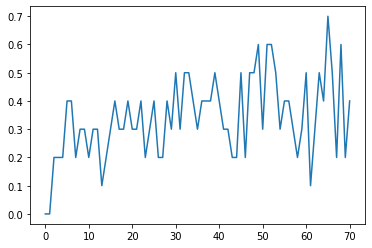

antipalos
antipalos
klepsimo
[ 4.2411077e-01 -2.5753188e-03  2.8757399e-03  1.2355995e-03
  4.3392119e-01 -8.4563447e-03 -6.1809612e-03 -7.9538336e-04
  4.4102901e-01 -6.9980272e-03  4.5102286e-01 -2.7387824e-03
 -6.2884518e-04 -4.3402277e-02  0.0000000e+00  0.0000000e+00
  1.0000000e+00]
---Episode reward: -120.14820616662365 score [0] steps 52 episode= 701 ---
shout entos periohis Ball Position 0.6725784 -0.006877432 0.11524594 episode 702 step= 76
goal episode 702 step= 90
---Episode reward: 60.97720266719358 score [1] steps 91 episode= 702 ---
shout entos periohis Ball Position 0.67045355 -0.02721807 0.17809406 episode 703 step= 75
goal episode 703 step= 91
---Episode reward: 60.985295330988365 score [1] steps 92 episode= 703 ---
shout entos periohis Ball Position 0.65603495 -0.0007882193 0.11108645 episode 704 step= 76
antipalos
goal episode 704 step= 100
---Episode reward: 60.98077417818814 score [1] steps 101 episode= 704 ---
goal episode 705 step= 95
---Episode reward: 60.98520

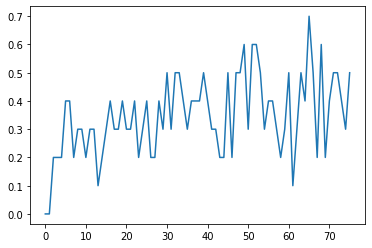

antipalos
antipalos
klepsimo
[ 5.21605551e-01 -8.79428722e-03  9.19138640e-03  7.12974213e-09
  6.49447501e-01  2.15982250e-03  6.23604842e-03 -4.97349421e-04
  6.57674730e-01  3.16910236e-03  1.11036584e-01 -2.39012158e-03
  4.78818401e-05  2.76972714e-04  0.00000000e+00  0.00000000e+00
  1.00000000e+00]
---Episode reward: -120.08320301305791 score [0] steps 77 episode= 751 ---
antipalos
antipalos
klepsimo
[ 6.5033239e-01 -8.6730188e-03  5.3595747e-03 -7.7573022e-06
  6.3293403e-01 -9.2804832e-03  4.0619390e-04  1.9138480e-07
  6.3585705e-01 -8.7651750e-03  1.0869575e-01  0.0000000e+00
 -0.0000000e+00 -1.7975228e-02  0.0000000e+00  0.0000000e+00
  1.0000000e+00]
---Episode reward: -130.08978140224283 score [0] steps 78 episode= 752 ---
PROSOXI lathos sprint
Mpala piso apo kentro
---Episode reward: -18.281929726053022 score [0] steps 69 episode= 753 ---
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipal

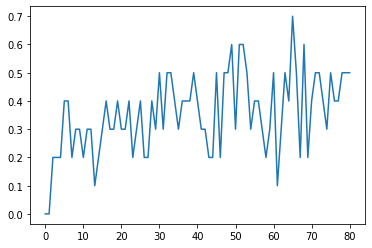

perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
shout entos periohis Ball Position 0.66869444 -0.0019757352 0.1269645 episode 801 step= 72
goal episode 801 step= 81
---Episode reward: 50.97859344229545 score [1] steps 82 episode= 801 ---
antipalos
antipalos
klepsimo
[ 5.5178958e-01 -1.3121262e-02 -1.3780141e-04 -4.5524226e-03
  5.2620888e-01 -3.8346499e-03  5.9509412e-03 -1.1519782e-03
  5.3858286e-01 -1.4595352e-02  3.4179968e-01  1.7754126e-03
 -1.3856473e-03  1.6128685e-01  0.0000000e+00  0.0000000e+00
  1.0000000e+00]
---Episode reward: -120.11900572038958 score [0] steps 55 episode= 802 ---
Ball is out by player - 5
---Episode reward: -10.073425168062034 score [0] steps 82 episode= 803 ---
antipalos
antipalos
klepsimo
[ 4.7185096e-01 -5.678250

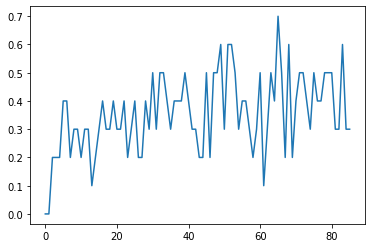

PROSOXI lathos sprint
PROSOXI lathos sprint
mpala ektos orion
---Episode reward: -25.11195572871391 score [0] steps 100 episode= 851 ---
antipalos
antipalos
klepsimo
[ 4.3213350e-01 -1.1084383e-02  4.7259219e-03 -1.4812869e-03
  4.3989262e-01 -4.0498874e-03 -5.2574179e-03  7.4860989e-04
  4.5133075e-01 -6.8230955e-03  1.3422684e-01  4.2261658e-03
 -4.7110440e-04  2.8774410e-02  0.0000000e+00  0.0000000e+00
  1.0000000e+00]
---Episode reward: -120.1451152118825 score [0] steps 51 episode= 852 ---
shout entos periohis Ball Position 0.6645854 -0.0067635817 0.11723479 episode 853 step= 75
Ball is out by player - 5
---Episode reward: -10.03051598917924 score [0] steps 92 episode= 853 ---
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
antipalos
antipalos
klepsimo
[ 5.4574305e-01 -8.6902063e-03  1.1522980e-02 -4.9908195e-08
  6.6753870e-01 -1.0421746e-02  6.2823296e-03 -9.9673798e-06
  6.7531574e-01 -1.0887785e-02  1.1104595e-01 -2.4730186e-03
 -7.1873197e-05  3.2368689e-04

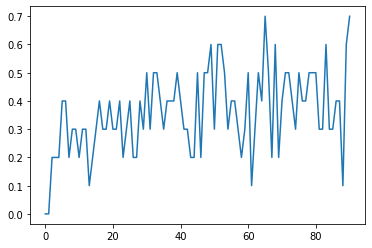

Ball is out by player - 5
---Episode reward: -10.023271550756505 score [0] steps 86 episode= 901 ---
goal episode 902 step= 89
---Episode reward: 60.97581850257812 score [1] steps 90 episode= 902 ---
shout entos periohis Ball Position 0.66926295 -0.0010806997 0.1133686 episode 903 step= 76
goal episode 903 step= 86
---Episode reward: 50.98114903911903 score [1] steps 87 episode= 903 ---
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
sprint afou exei perasei
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
peras

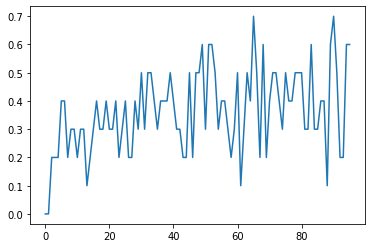

shout entos periohis Ball Position 0.6609349 0.0026334976 0.11228124 episode 951 step= 96
goal episode 951 step= 107
---Episode reward: 60.975020771613 score [1] steps 108 episode= 951 ---
PROSOXI lathos sprint
PROSOXI lathos sprint
mpala ektos orion
---Episode reward: -15.10650331037332 score [0] steps 94 episode= 952 ---
shout entos periohis Ball Position 0.66295874 -0.017590618 0.111281365 episode 953 step= 80
Ball is out by player - 5
---Episode reward: -20.027786828364402 score [0] steps 94 episode= 953 ---
shout entos periohis Ball Position 0.6731101 -0.0053801527 0.11128242 episode 954 step= 77
Ball is out by player - 5
---Episode reward: -10.027683350440245 score [0] steps 92 episode= 954 ---
shout entos periohis Ball Position 0.6470592 -0.007955905 0.110380284 episode 955 step= 76
mpala ektos orion
---Episode reward: -20.11559820351888 score [0] steps 102 episode= 955 ---
antipalos
antipalos
klepsimo
[ 6.9036239e-01  8.2700970e-03  8.9469580e-03 -1.0862349e-03
  7.0220125e-01 

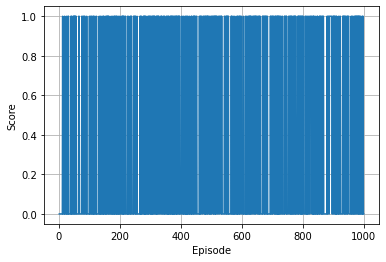

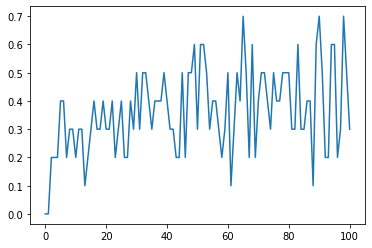

shout entos periohis Ball Position 0.6687724 -0.0056726257 0.15567145 episode 1001 step= 75
mpala ektos orion
---Episode reward: -20.111831565772935 score [0] steps 107 episode= 1001 ---
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
antipalos
antipalos
klepsimo
[ 0.5535552  -0.05097239  0.00919104 -0.          0.05075854 -0.17089593
 -0.01139998 -0.00420406  0.03759618 -0.1749

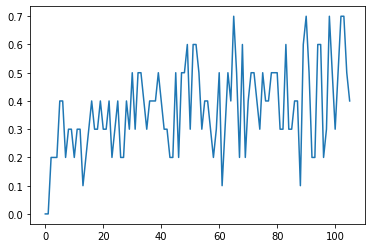

Mpala piso apo kentro
---Episode reward: -23.283095106939644 score [0] steps 68 episode= 1051 ---
goal episode 1052 step= 107
---Episode reward: 55.976834442926204 score [1] steps 108 episode= 1052 ---
shout entos periohis Ball Position 0.6753296 0.023554092 0.16259317 episode 1053 step= 74
goal episode 1053 step= 89
---Episode reward: 60.98037982688042 score [1] steps 90 episode= 1053 ---
shout entos periohis Ball Position 0.76510584 0.060898777 0.10931548 episode 1054 step= 79
goal episode 1054 step= 90
---Episode reward: 60.980389059289806 score [1] steps 91 episode= 1054 ---
Mpala piso apo kentro
---Episode reward: -23.284423037331997 score [0] steps 66 episode= 1055 ---
antipalos
antipalos
klepsimo
[ 4.2163464e-01 -1.0383296e-02  3.1395059e-03 -1.7337890e-03
  4.3178701e-01 -4.7732899e-03 -4.8605762e-03  6.1121071e-04
  4.3646395e-01 -3.5413632e-03  1.2687871e-01 -5.6176251e-03
  6.5813278e-05  4.6396226e-02  0.0000000e+00  0.0000000e+00
  1.0000000e+00]
---Episode reward: -120.14

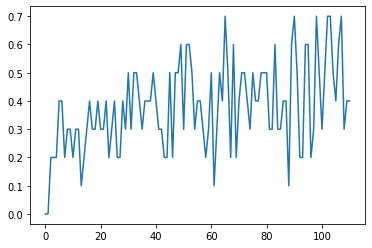

antipalos
antipalos
klepsimo
[ 4.79156315e-01 -8.40546843e-03  6.92422688e-03  1.39398256e-03
  4.66023743e-01 -4.50857915e-03  2.47657159e-03 -1.68410232e-04
  4.74011153e-01 -6.07907632e-03  1.10739976e-01  1.28712403e-04
  1.56332680e-04  7.39974435e-03  0.00000000e+00  0.00000000e+00
  1.00000000e+00]
---Episode reward: -120.13830867833182 score [0] steps 60 episode= 1101 ---
shout entos periohis Ball Position 0.6721241 -0.011945484 0.11172829 episode 1102 step= 76
goal episode 1102 step= 97
---Episode reward: 60.9766481673111 score [1] steps 98 episode= 1102 ---
shout entos periohis Ball Position 0.70074016 -0.0010989095 0.14623128 episode 1103 step= 66
goal episode 1103 step= 79
---Episode reward: 60.972390980604 score [1] steps 80 episode= 1103 ---
dribble prin ton antipalo
perase ton antipalo kanonika
perase ton antipalo kanonika
mpala ektos orion
---Episode reward: -20.110628135400844 score [0] steps 83 episode= 1104 ---
dribble prin ton antipalo
goal episode 1105 step= 102
--

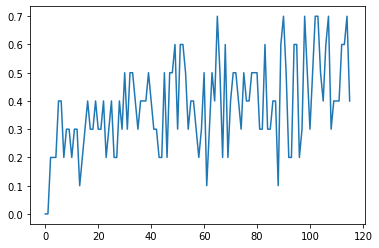

perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
shout entos periohis Ball Position 0.66438293 0.0018918295 0.11084552 episode 1151 step= 73
goal episode 1151 step= 95
---Episode reward: 60.97639568788448 score [1] steps 96 episode= 1151 ---
goal episode 1152 step= 103
---Episode reward: 60.97721490422578 score [1] steps 104 episode= 1152 ---
shout entos periohis Ball Position 0.7492571 0.06860644 0.11128055 episode 1153 step= 80
Ball is out by player - 5
---Episode reward: -10.042689038330527 score [0] steps 102 episode= 1153 ---
Ball is out by player - 5
---Episode reward: -10.105652284940989 score [0] steps 99 episode= 1154 ---
Mpala piso apo kentro
---Episode reward: -25.290609639901884 score [0] steps 72 episode= 1155 ---
antipalos
shout entos periohis Ball Position 0.67746294 0.00207949 0.11102622 episode 1156 step= 72
goal episode 1156 step= 81
---Episode reward: 50.981954596368695 score [1] steps 82 episode= 115

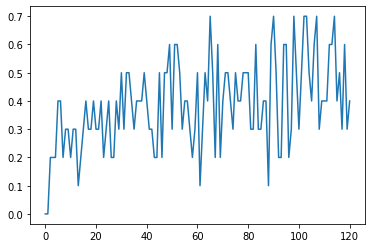

shout entos periohis Ball Position 0.6710851 -0.00870601 0.113132745 episode 1201 step= 75
goal episode 1201 step= 91
---Episode reward: 60.979875107172454 score [1] steps 92 episode= 1201 ---
goal episode 1202 step= 84
---Episode reward: 60.9782705824003 score [1] steps 85 episode= 1202 ---
antipalos
mpala ektos orion
---Episode reward: -20.106924448915684 score [0] steps 88 episode= 1203 ---
shout entos periohis Ball Position 0.6700235 -0.007951796 0.11531707 episode 1204 step= 75
goal episode 1204 step= 90
---Episode reward: 60.97749052561459 score [1] steps 91 episode= 1204 ---
shout entos periohis Ball Position 0.7756934 0.0011559635 0.1093176 episode 1205 step= 77
Ball is out by player - 5
---Episode reward: -10.018948689064077 score [0] steps 88 episode= 1205 ---
shout entos periohis Ball Position 0.6698464 -0.009056172 0.10956507 episode 1206 step= 73
goal episode 1206 step= 83
---Episode reward: 50.97552800776818 score [1] steps 84 episode= 1206 ---
shout entos periohis Ball P

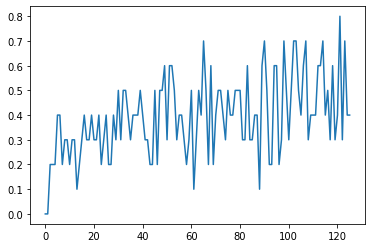

shout entos periohis Ball Position 0.66738975 0.009897879 0.10894945 episode 1251 step= 75
goal episode 1251 step= 89
---Episode reward: 60.97894888791867 score [1] steps 90 episode= 1251 ---
antipalos
antipalos
klepsimo
[ 6.1977375e-01 -4.3993194e-02  7.6658586e-03 -2.6993488e-03
  7.8627199e-01 -4.4621313e-03  4.7662677e-03  5.3618156e-04
  7.8406018e-01 -4.0475023e-03  1.1059216e-01 -1.8722126e-03
 -3.5668163e-05 -1.9444854e-03  0.0000000e+00  0.0000000e+00
  1.0000000e+00]
---Episode reward: -120.04529822328962 score [0] steps 88 episode= 1252 ---
PROSOXI lathos sprint
PROSOXI lathos sprint
Mpala piso apo kentro
---Episode reward: -23.2845749132572 score [0] steps 66 episode= 1253 ---
ball is out -15 episode 1254 Ball Position 1.0107566 -0.32050577 0.109982245 step= 97
---Episode reward: -20.09880116924192 score [0] steps 98 episode= 1254 ---
antipalos
Ball is out by player - 5
---Episode reward: -10.031649081338852 score [0] steps 101 episode= 1255 ---
dribble prin ton antipalo
go

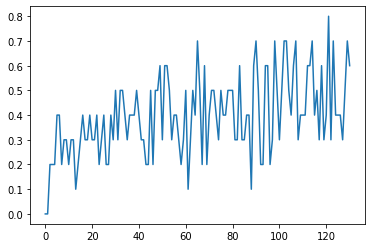

goal episode 1301 step= 95
---Episode reward: 60.97339060871279 score [1] steps 96 episode= 1301 ---


In [ ]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')  #List with the 115 states 


#CUSTOMIZE ACTION LIST AND OBSERVATIONS
Action_list=[4,5,6,12,13,14,15,17,18]
#print(env.action_space.n)
#Create Objects


agent = Agent(gamma=0.99,epsilon=1.0 ,batch_size = 64 ,lr=0.00115 ,input_dims= [17], n_actions = len(Action_list) )# batch = best 256
all_prints = All_prints()
#cus_rew =Custom_Rewards()

scores,ep_history =[],[]

steps=0
terminal =0 # an skorarei se pano apo enan arithmo paixnidion stamatao tin ekpaideysi 
episode =0
shout =0


num_of_eps = 4001
eps_rew=0
rew_list =[]
score_list = []
step_list =[]
goal_steps=[]
avg_score_list = []
steal = []
for i in range(num_of_eps) : 
  score =0 
  done=False 
  eps_rew=0
  observation =env.reset()
  #print("Pinakas apo observations",observation)
  act =0 #first action will be to move right 
  shout=0 #mporei na kanei shout 1 fora se kathe ep
  timer=0 # an klepsei tin mpala kai tin kratisei pano apo 4 steps stamata
  forward=0 #an perasei ton antipalo kai kanei sprint tin proti fora  einai +5
  sprint=0 # an kanei tin proti fora sprint + 20
  dribble =0 # tin proti fora poy kanei dribble na pairnei +10
  checkpoint_reward=[1,1,1,1,1]
  steps=0

  while not done:

    #CUSTOMIZE ACTIONS HERE 
   
    
    #print("------------")
    #print("Ball X-Y-Z Axis",observation[88],observation[89],observation[90],"||","direct",observation[91],observation[92],observation[93],"Katoxi",observation[95],observation[96])
    #print("Player X-Axis Y-Axis",observation[2],observation[3] ,"episode",i) SOSTO
    #print("------------")

    #print(observation[0],observation[1],observation[2],observation[3],observation[4],observation[5])
    

   
     
      
 
    if(act ==0 ): # proti praksi ena bima deksia
      
      # print("action 5",Action_list[action])
      new_observation,reward,done,info = env.step(5)
      
      act=1
      #print(new_observation)
    #print("Sto Else",observation[94],observation[95],observation[96])
    

    #CUSTOM ACTIONS
    action = agent.choose_action(observation) # from 1-9s which is index to action list

    #while((observation[4]> observation[0] )  and (Action_list[action]==13 or Action_list[action]==15) and observation[14]==1): #den kanei sprint prin perasei ton paikti
     # action = agent.choose_action(observation)

    #while(observation[4] - observation[0] >0.2 and observation[4]-observation[0]>0 and (Action_list[action]==17 or Action_list[action]==18 )):
     # action = agent.choose_action(observation)

    while((observation[0] > observation[4] +0.02)  and (Action_list[action]==17 or Action_list[action]==18 )): # an ton perasei min kanei drible 
      action = agent.choose_action(observation)
    while((observation[0]<0.65)  and (Action_list[action]==12)): #Den kanei shout ektos periohis
      action = agent.choose_action(observation)
     
    #if(observation[0]>observation[4]+0.05  and observation [0] < 0.6):
      #print("perase kai sprint")
      #action = 4

      #print("Player Position:",observation[0],observation[1])
      #print("Player Direction:",observation[2],observation[3])
      #print("Ball Position:",observation[4],observation[5],observation[6])
      #print("Ball Direction:",observation[7],observation[8],observation[9])

    if(shout==0):   #ama kanei shout na min kanei tipota meta 
      new_observation,reward,done,info = env.step(Action_list[action])
      
      if(Action_list[action]==12):
        #print("EKANE SHOUT")
        shout=1
    else:
      #print("MPIKE STO ELSE")
      new_observation,reward,done,info = env.step(0)
      action=0 #Ta parakato if den pianoun to Action_list[action]=12 alla gia Action_list[action]=4

#CUSTOM REWARDS-------------------------------
    if(done ==1 and reward ==1): #if agent scores , wins +50
      print("goal","episode",i,"step=",steps)
      reward += 60 

   
    if(done ==1 and reward == 0): # an bgei i mpala apo ton antipalo einai -15 , a bgei apo ton paikti einai -5 
      if(shout ==1 ):
        reward = reward - 10
        print("Ball is out by player - 5")
        terminal =0
      else:
        reward = reward -20 #12
        print("ball is out -15","episode",i,"Ball Position",observation[8],observation[9],observation[10],"step=",steps)
        terminal =0



      terminal= terminal +1
      goal_steps.append(steps)


    if(observation[16]==1 ):  # an klepsei tin mpala kai tin kratisei pano apo 4 steps stamata
      print("antipalos")
      timer=timer+1
      reward = reward - 50
      
     
      if(timer == 2 ):
        reward = reward - 60
        print("klepsimo")
        done = 1
        terminal =0
        print(observation)
      if (timer>2 and timer <  4 ):
        reward = reward - 50
        print("klepsimo")
        #done =1
      if (timer>4 and timer <6 ):
        reward = reward - 20
        print("klepsimo")
        
      if(timer >= 8):
        done=1
        reward = reward -20
        print("klepsimo")

    if(observation[8]< 0.0 ):  #An i mpala paei piso apo to kentro telos paixnidiou
      print("Mpala piso apo kentro")
      reward = reward-25
      done =1 

    if(observation[9]>0.35 or observation[9]<-0.35):
      reward = reward - 20
      print("mpala ektos orion")
      done = 1

    #----------------
    #if(observation[14]== 0): #an den exo stin katoxi tin mpala einai -5
     # reward =reward-5
    #if(observation[14] == 1): # an exo tin katoxi na einai +2
     #reward =reward +5

    if ((observation[8] > observation[0] + 0.05) and (observation[9] - observation[1] <=0.03) or(observation[9] - observation[1] >=-0.03) ) and Action_list[action]==5: #an kanei deksia kai exei ti mpala
      reward = reward + 5
          
    if (observation[14]!=1):
      reward = reward -5
      #print("mpala oxi dikia moy")
    if(observation[16]==1):
      reward = reward - 10

    if(observation[4] - observation[0] > 0.2 and Action_list[action]==5): # an einai makria o antipalos kai kano bima deksia +2
        reward =reward + 2
    if(observation[4] - observation[0] > 0.2 and (Action_list[action] == 14 or Action_list[action] == 15 or Action_list[action] == 18 )): # an meinei akinitos  einai -2
        reward = reward - 5

    if((observation[0] > observation [4] +0.1) and (Action_list[action]==13)and (observation[14]==1)): #An peraso ton antipalo kai kano sprint tin proti fora +5
      print("perase ton antipalo kai sprint NO REWARD")
      #reward =reward + 10 
    #----------------

    if((observation[4]-observation[0]< 0.05)and dribble==0 and (observation[4]-observation[0]> 0) and (Action_list[action]==17)):  # an kanei dirbble konta ston antipalo prin erthei se ayton +15 
      print("dribble prin ton antipalo")
      dribble =1
      #reward = reward + 10



    if(((observation[0] > observation [4] + 0.05) and observation[14]== 1 ) and done!= 1 and shout ==0 and (observation [0]>-0.2 or observation[0]<0.2)):  # an perasei ton antipalo einai +5
      print("perase ton antipalo kanonika")
      reward = reward + 2
      if(forward ==0):
        forward =1
        reward = reward + 35
      #done =1
      #print(observation)
      
      """if((observation[0]>0.6) and (Action_list[action]==12)) : #an ton perasei kai mpei perioxi kai shoutarei einai + 10
        print("Shout entos periohis")
        reward = reward +15
      #if((observation[0] > observation [4] +0.1) and (Action_list[action]==13) and (sprint ==0)and (observation[14]==1)): # an ton perasei k kanei sprint +5
        #reward = reward + 8
      if((Action_list[action]==13) and (observation[14]==1)): # ton pernaei kai paei deksia 
        reward = reward + 8
      if((Action_list[action]==17) or (Action_list[action]==18) ): # an ton perasei kai kanei drible i stamatisei -20
        print("ton perase kai kanei drible h stamatisei", Action_list[action])
        reward = reward - 20"""

    
    if((observation[4] > observation[0]) and (Action_list[action]==13 or Action_list[action]==15) and observation[14]==1): # an einai apenanti o paiktis kai kano sprint -5
      print("PROSOXI lathos sprint")
      reward = reward - 10                                     #PROSOXI EDO

    if((observation[4] < observation[0] -0.08)and sprint== 0 and observation[8] <0.65 and done != 1 and shout ==0 and  (Action_list[action]==13 or Action_list[action]==15) and observation[14]==1 and (observation[1]>-0.2 or observation[1]<0.2)):
       reward = reward + 25
       sprint=1
       print("sprint afou exei perasei")
  

    if((observation[0]<0.65)  and (Action_list[action]==12)): #an shoutarei prin th megali perioxh -2
      reward= reward -200
      done=1
      print("shout ektos periohis","episode",i,"step=",steps)
      
    if((observation[0]>0.6) and (Action_list[action]==12) and observation[0]<0.75 and observation[0] >observation[4] +0.01 ): #an shoutarei mesa ti megali periohi +10
      reward= reward + 15
      print("shout entos periohis Ball Position",observation[8],observation[9],observation[10],"episode",i,"step=",steps)
    
    if((observation[0]>0.6) and (Action_list[action]!=12) and observation[0]<0.75 and observation[0] >observation[4] +0.01 ): #an shoutarei mesa ti megali periohi +10
      reward= reward - 10
    

    
    reward = reward - ( math.sqrt( ((0.935 - observation[8])**2) + (0 -observation[9])**2 ) *0.3) #oso pio makria einai toso perissotero xanei

    #END OF CUSTOM REWARDS ----------------------------- 
 
    
   
    score+= reward/11

    #for prints
    
    #all_prints.print_who_scored(reward)
    

    agent.store_transition(observation,action,reward,new_observation,done)
    agent.learn()
    observation = new_observation

    scores.append(score)
    ep_history.append(agent.epsilon)

    avg_score= np.mean(scores)


    steps=steps+1
    

#---- BE CAREFUL OF THE WHILE !!! HERE IS EPIDOSE ENDING--------
  #print("Reward",eps_rew,"Episode",i,"Steps" , steps)
  
  eps_rew+=reward
  step_list.append(steps)
  

  val = info.values()
  list_val=list(val)
  score_list.append(list_val)

  rew_list.append(eps_rew)
  episode = episode +1 

  print("---Episode reward:", reward ,"score",list_val,"steps",steps,"episode=",i,"---")
  #terminate if 500 episodes are correct 
  if(terminal ==30):
    print("!!! END OF TRAINING 20 CONTINUOUS GOALS !!!")
    print("---Avg reward last:", np.mean(rew_list[-10:]),"Avg score last",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
    all_prints.rew_graph(rew_list[-i:],i)
    all_prints.step_graph(goal_steps[-20:],20)
    break

# PRINTS
  if (i % 10)== 0 :
      print("---Avg reward last:", np.mean(rew_list[-10:]),"Avg score last",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
      avg_score_list.append(np.mean(score_list[-10:]))
      #print(score_list)

  if (((i % 1000)== 0) and i!=0) :
      all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
  if(((i%50)==0) and i!=0):
     plt.plot(avg_score_list)
     plt.show()
  #if(((i%200)==0) and i!=0):
    #plt.plot(steal)
    #plt.show()
  #EPISODE PRINTS
  #all_prints.printstats(i,rew_list,eps_rew,agent.epsilon)
  
  #eps_rew=0 #GIA NA BGALO SYNOLIKO GRAFIMA TO AFAIRO AYTO



#print("Avg score last:", np.mean(rew_list[-10:]),"Avg score",np.mean(score_list),"Avg steps",np.mean(step_list[-10:]),"episode=",i)
#all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
      
a = len(goal_steps)
all_prints.step_graph(goal_steps[-a:],len(goal_steps))